In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfcx
from scipy.optimize import curve_fit
import pandas as pd

plt.rcParams['savefig.dpi'] = 300
plt.style.use('seaborn-v0_8-whitegrid')

#Unit definitions (SI values in Hartree atomic units):
Tesla =  1/2.35051756758e5
ns = 1/2.4188843265857e-8
mu_B = 0.5

In [2]:
def Fperp(x):
    return x**2 / (1 + x**2)

def Fpar(x):
    return 1 - (np.sqrt(np.pi/2) / x) * erfcx(np.sqrt(0.5) / x)

def model_T1(B, tau_s0, g, tau_p, sigma_perp, sigma_par):
    return 1 / (
        1/tau_s0
        + Fperp(g * mu_B * B * tau_p) * 2*(sigma_perp/g)**2/tau_p
    )

def model_T2(B, tau_s0, g, tau_p, sigma_perp, sigma_par):
    return 1 / (
        1/tau_s0
        + Fperp(g * mu_B * B * tau_p) * (sigma_perp/g)**2/tau_p
        + Fpar(sigma_par * mu_B * B * tau_p)/tau_p
    )

def model_T2s(B, tau_s0, g, tau_p, sigma_perp, sigma_par):
    return 1 / (
        1/model_T2(B, tau_s0, g, tau_p, sigma_perp, sigma_par)
        + Fpar(sigma_par * mu_B * B * tau_p) * 0.4414 * sigma_par * mu_B * B
    )

def model_T2p(B, tau_s0, g, tau_p, sigma_perp, sigma_par):
    return 1 / (
        1/model_T2(B, tau_s0, g, tau_p, sigma_perp, sigma_par) 
        - 1/(2*model_T1(B, tau_s0, g, tau_p, sigma_perp, sigma_par))
    )

def fit_function(B_which, *log_params):
    # Unpack inputs
    B, which = B_which
    params = np.exp(log_params)
    # Compute T1, T2 or T2* model based on which
    sel1 = np.where(which == 1.0)[0]
    sel2 = np.where(which == 2.0)[0]
    sel2s = np.where(which == 3.0)[0]
    result = np.zeros_like(B)
    result[sel1] = model_T1(B[sel1], tau_s0, g, *params)
    result[sel2] = model_T2(B[sel2], tau_s0, g, *params)
    result[sel2s] = model_T2s(B[sel2s], tau_s0, g, *params)
    return np.log(result)

Fit parameters:
tau_p/ns = 0.20047239550271884
sigma_perp = 0.055136021352268236
sigma_par = 0.0787752131305083


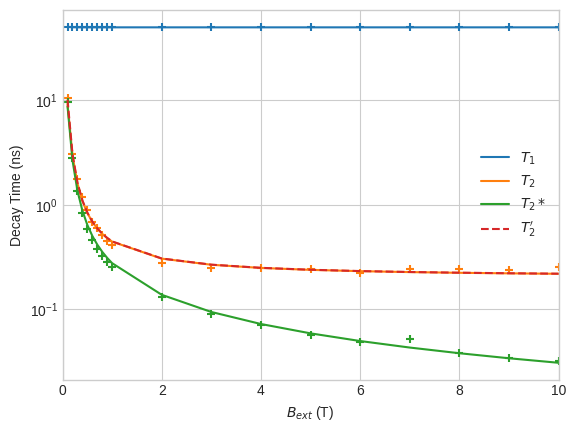

In [3]:
# CsPbBr3
data = pd.read_csv("spin-times-CPB.csv")
B = data["B"] * Tesla
T1 = data["T1"] * ns
T2 = data["T2"] * ns
T2s = data["T2*"] * ns

# DFT parameters
tau_s0 = 65.0 * ns
g = 2.547
tau_p = 0.222 * ns
sigma_perp = 0.115
sigma_par = 0.0832

# Fit
B_which = np.vstack((
    np.concatenate((B, B, B)),
    np.repeat([1.0, 2.0, 3.0], len(B))
))
logT = np.log(np.concatenate((T1, T2, T2s)))
popt, _ = curve_fit(fit_function, B_which, logT, np.log([tau_p, sigma_perp, sigma_par]))
tau_p, sigma_perp, sigma_par = np.exp(popt)
print("Fit parameters:")
print(f"{tau_p/ns = }")
print(f"{sigma_perp = }")
print(f"{sigma_par = }")

plt.scatter(B/Tesla, T1/ns, marker="+")
plt.plot(B/Tesla, model_T1(B, tau_s0, g, tau_p, sigma_perp, sigma_par)/ns, label="$T_1$")

plt.scatter(B/Tesla, T2/ns, marker="+")
plt.plot(B/Tesla, model_T2(B, tau_s0, g, tau_p, sigma_perp, sigma_par)/ns, label="$T_2$")

plt.scatter(B/Tesla, T2s/ns, marker="+")
plt.plot(B/Tesla, model_T2s(B, tau_s0, g, tau_p, sigma_perp, sigma_par)/ns, label="$T_2*$")

plt.plot(B/Tesla, model_T2p(B, tau_s0, g, tau_p, sigma_perp, sigma_par)/ns, label="$T_2'$", linestyle="dashed")

plt.ylabel("Decay Time (ns)")
plt.xlabel("$B_{ext}$ (T)")
plt.semilogy()
plt.xlim(0, 10)
plt.legend()
plt.savefig("CPB_model_fit.pdf", bbox_inches="tight")
plt.show()

Fit parameters:
tau_p/ns = 0.00149922605499571
sigma_perp = 0.006518364315553609
sigma_par = 0.002238592462174056


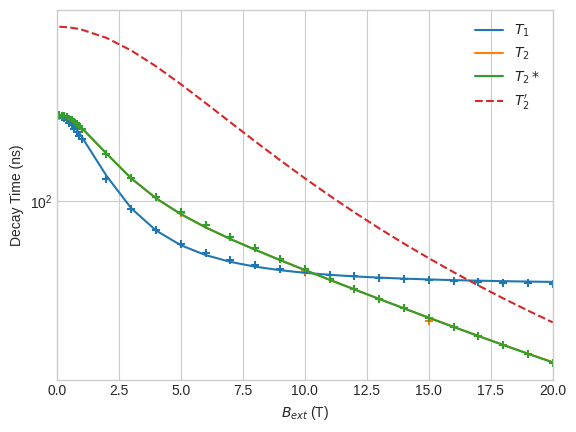

In [4]:
# Si
data = pd.read_csv("spin-times-Si.csv")
B = data["B"] * Tesla
T1 = data["T1"] * ns
T2 = data["T2"] * ns
T2s = data["T2*"] * ns
# --- only selected T2 calculated:
sel2 = np.where(np.isfinite(T2))[0]
T2 = T2[sel2]

# DFT parameters
tau_s0 = 194.77 * ns
g = 2.000
tau_p = 0.00207 * ns
sigma_perp = 0.00614
sigma_par = 0.00119

# Fit
B_which = np.vstack((
    np.concatenate((B, B[sel2], B)),
    np.repeat([1.0, 2.0, 3.0], [len(T1), len(T2), len(T2s)])
))
logT = np.log(np.concatenate((T1, T2, T2s)))
popt, _ = curve_fit(fit_function, B_which, logT, np.log([tau_p, sigma_perp, sigma_par]))
tau_p, sigma_perp, sigma_par = np.exp(popt)
print("Fit parameters:")
print(f"{tau_p/ns = }")
print(f"{sigma_perp = }")
print(f"{sigma_par = }")

plt.scatter(B/Tesla, T1/ns, marker="+")
plt.plot(B/Tesla, model_T1(B, tau_s0, g, tau_p, sigma_perp, sigma_par)/ns, label="$T_1$")

plt.scatter(B[sel2]/Tesla, T2/ns, marker="+")
plt.plot(B/Tesla, model_T2(B, tau_s0, g, tau_p, sigma_perp, sigma_par)/ns, label="$T_2$")

plt.scatter(B/Tesla, T2s/ns, marker="+")
plt.plot(B/Tesla, model_T2s(B, tau_s0, g, tau_p, sigma_perp, sigma_par)/ns, label="$T_2*$")

plt.plot(B/Tesla, model_T2p(B, tau_s0, g, tau_p, sigma_perp, sigma_par)/ns, label="$T_2'$", linestyle="dashed")

plt.plot()

plt.ylabel("Decay Time (ns)")
plt.xlabel("$B_{ext}$ (T)")
plt.semilogy()
plt.xlim(0, 20)
plt.legend()
plt.savefig("Si_model_fit.pdf", bbox_inches="tight")
plt.show()